# ✨ Multi-Agents System

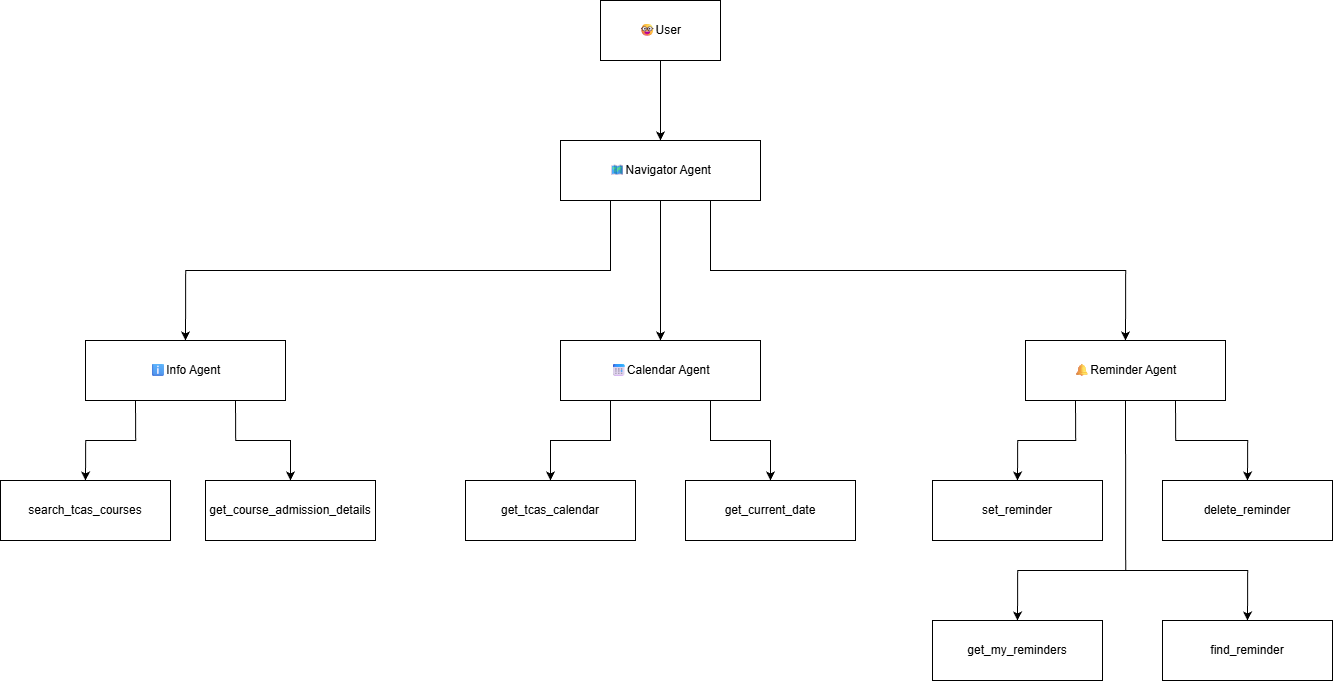
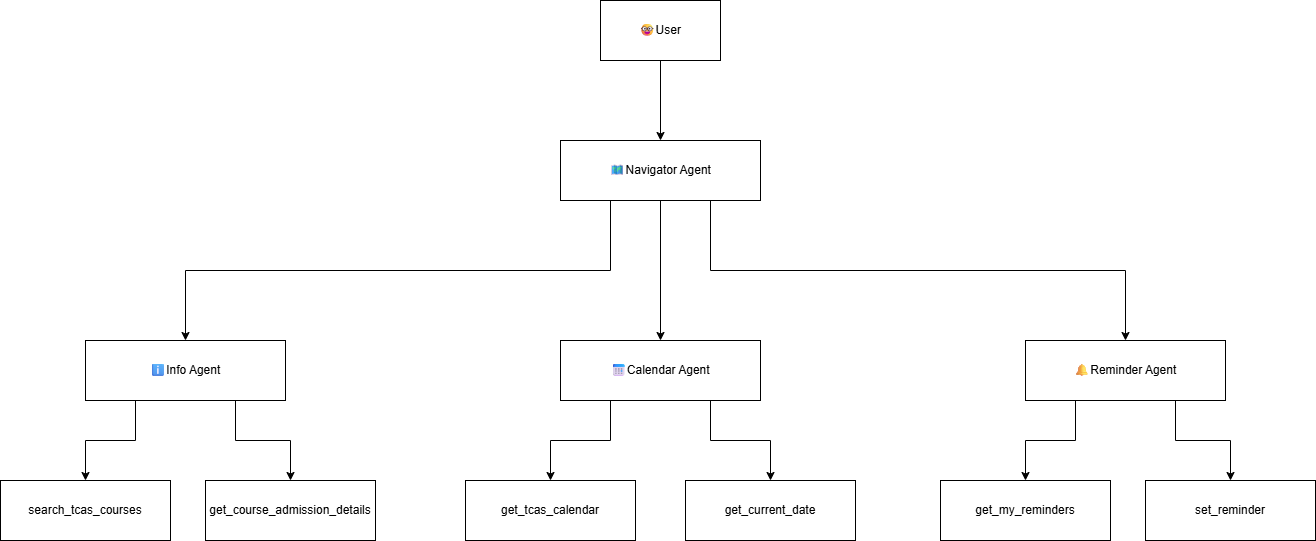

# ⚙️ Section 1: Setup

## 1.1 Configure your API Keys and URL

In [ ]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_CLOUD_PROJECT_ID = UserSecretsClient().get_secret("GOOGLE_CLOUD_PROJECT_ID")
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"

    SUPABASE_DB_CS = UserSecretsClient().get_secret("SUPABASE_DB_CS")
    SUPABASE_DB_KEY = UserSecretsClient().get_secret("SUPABASE_DB_KEY")
    SUPABASE_DB_URL = UserSecretsClient().get_secret("SUPABASE_DB_URL")
    COLLECTION_NAME = "tcas69_programs"

    TCAS_URL = UserSecretsClient().get_secret("TCAS_URL")
    CALENDAR_FILE_PATH = UserSecretsClient().get_secret("CALENDAR_FILE_PATH")
    
    print("✅ API keys and URL setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please make sure you have added All secrets to your Kaggle secrets. Details: {e}")

## 1.2 Install & Import components

In [ ]:
!pip install psycopg2

## 1.3 Helper function

In [ ]:
import json
import requests
import datetime
import uuid
import psycopg2
from typing import Any, Dict

from google.genai import types

from google.adk.agents import LlmAgent, Agent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner, Runner
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor
from google.adk.apps.app import App, ResumabilityConfig, EventsCompactionConfig
from google.adk.tools.function_tool import FunctionTool
from google.adk.tools import load_memory, preload_memory

import vertexai
from vertexai import agent_engines

print("✅ All components imported successfully.")

In [ ]:
# Define helper functions that will be reused throughout the notebook

from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers

# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]['base_url']

    try:
        path_parts = baseURL.split('/')
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix

print("✅ Helper functions defined.")

## 1.4 Configure retry option

In [ ]:
retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# 🛠️ Section 2: Tools

## 2.1 Define tools for Info Agent ℹ️

In [ ]:
def search_tcas_courses(university: str, faculty: str, major: str = "") -> list:
    """
    Search for TCAS courses using structured filters.
    
    Args:
        university: Full name of the university (e.g., "Chulalongkorn University").
        faculty: Name of the faculty (e.g., "Faculty of Engineering").
        major: Name of the major or curriculum (e.g., "Computer Engineering").
        
    Returns:
         List of result items.
    """
    # --- Configuration ---
    url = f"{SUPABASE_DB_URL}/rest/v1/{COLLECTION_NAME}"
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
        "Content-Type": "application/json"
    }

    # --- Construct Query Params ---
    # 1. Basic Filters (Implicitly AND)
    params = {
        "select": "program_id,university_name_th,faculty_name_th,field_name_th,program_name_th,major_name_th,seats,cost,graduate_rate",
        "university_name_th": f"eq.{university}",
        "faculty_name_th": f"like.*{faculty}*",
        "limit": "10"
    }

    # 2. Complex OR Filter (Program OR Field OR Major)
    if major:
        # PostgREST syntax for OR: or=(col.op.val,col.op.val)
        # Note: We use * for wildcards inside the filter string
        or_condition = (
            f"(program_name_th.like.*{major}*,"
            f"field_name_th.like.*{major}*,"
            f"major_name_th.like.*{major}*)"
        )
        params["or"] = or_condition

    try:
        # --- STEP 1: Execute Request ---
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        results = response.json()

        # --- STEP 2: Check Results ---
        if not results:
            return ["No courses match."]

        # --- STEP 3: Format Output ---
        output_list = [{
            "program_id": item.get("program_id"),
            "university": item.get("university_name_th"),
            "faculty": item.get("faculty_name_th"),
            "field": item.get("field_name_th"),
            "program": item.get("program_name_th"),
            "major": item.get("major_name_th"),
            "seats": item.get("seats"),
            "cost": item.get("cost")
        } for item in results]
        
        return output_list

    except requests.exceptions.RequestException as e:
        return [f"Error searching courses: {e}"]

In [ ]:
# --- Helper Functions ---
def format_requirements(round_data):
    reqs = []
    conditions = [
        ('only_formal', 'รับผู้สมัครที่จบจาก รร. หลักสูตรแกนกลาง'),
        ('only_international', 'รับผู้สมัครที่จบจาก รร. หลักสูตรนานาชาติ'),
        ('only_vocational', 'รับผู้สมัครที่จบจาก รร. หลักสูตรอาชีวะ'),
        ('only_non_formal', 'รับผู้สมัครที่จบจาก รร. หลักสูตรตามอัธยาศัย (กศน.)'),
        ('only_ged', 'รับผู้สมัครที่จบหลักสูตร GED')
    ]
    for key, text in conditions:
        if round_data.get(key) == 1: reqs.append(f"- {text}")
        elif round_data.get(key) == 2: reqs.append(f"- ไม่{text}")
    gpax = round_data.get('min_gpax')
    if gpax and gpax > 0: reqs.append(f"- คะแนน GPAX ต่ำสุด: {gpax}")
    return "\n".join(reqs)

def format_scores(scores_data):
    if not scores_data: return "- ไม่ใช้คะแนนสอบข้อเขียน (พิจารณาจากเกรด/พอร์ต)"
    lines = []
    for key, val in scores_data.items():
        if val and val > 0: lines.append(f"- {key}: {val}%")
    return "\n".join(lines)

def get_course_admission_details(program_id: str, round: int = 0) -> str:
    """
    Get detailed admission requirements, scores, and round schedules for a specific Program ID.
    Use this tool ONLY when you have a specific 'program_id' (e.g., '10010121300501A').
    
    Args:
        program_id: The official 15-digit Program ID.
        round: The specific round if user provided. (if user not provided let it rount = 0)
    
    Returns:
        Detailed admission info, rounds, GPAX, and exam scores.
    """
    url = f"{TCAS_URL}/mytcas/rounds/{program_id}.json"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        
        if round:
            data = [item for item in data if int(item['type'][0]) == round]
        
        output_text = []
        for item in data:
            round_id = item.get('type', 'N/A')
            seats = item.get('receive_student_number', 0)
            req_str = format_requirements(item)
            score_str = format_scores(item.get('scores', {}))
            
            block = f"=== รอบที่ (Round): {round_id} ===\nรับ (Seats): {seats} คน\nคุณสมบัติ (Requirements):\n{req_str}\nคะแนน (Scores):\n{score_str}\n-----------------"
            output_text.append(block)
            
        return "\n".join(output_text) if output_text else "ไม่มีข้อมูลรอบรับสมัคร"
    except Exception as e:
        return f"ไม่สามารถดึงข้อมูลได้: {str(e)}"

## 2.2 Define tools for Calendar Agent 📅

In [ ]:
def _read_file_content(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        return "Error: File not found."

In [ ]:
def get_tcas_calendar(category: str) -> str:
    """
    Retrieves TCAS calendar information, exam schedules, or application fees based on the specified category.
    
    Args:
        category: The category of information to retrieve. Options are:
                  - 'rounds': TCAS Rounds 1-4 schedule (Portfolio, Quota, Admission, Direct Admission).
                  - 'alevel': A-Level exam schedule and application fees.
                  - 'tgat_tpat': TGAT/TPAT exam schedule and application fees.
                  - 'all': All available calendar information (use only when the user's query is very broad).
    
    Returns:
        A raw string containing the content from the relevant files (JSON or Markdown) 
        for the Agent to analyze and answer user questions.
    """
    
    if category == 'rounds':
        content = _read_file_content(f'{CALENDAR_FILE_PATH}/tcas_calendar.json')
        return f"TCAS Rounds 1-4 Calendar:\n{content}"
    
    elif category == 'alevel':
        return _read_file_content(f'{CALENDAR_FILE_PATH}/A-Level.md')
    
    elif category == 'tgat_tpat':
        return _read_file_content(f'{CALENDAR_FILE_PATH}/TGAT-TPAT.md')
        
    elif category == 'all':
        # Load all files (Use with caution regarding token limits)
        c1 = _read_file_content(f'{CALENDAR_FILE_PATH}/tcas_calendar.json')
        c2 = _read_file_content(f'{CALENDAR_FILE_PATH}/A-Level.md')
        c3 = _read_file_content(f'{CALENDAR_FILE_PATH}/TGAT-TPAT.md')
        return f"All Calendar Information:\n\n--- TCAS Rounds ---\n{c1}\n\n--- A-Level ---\n{c2}\n\n--- TGAT/TPAT ---\n{c3}"
    
    else:
        return "Error: Invalid category. Please choose 'rounds', 'alevel', or 'tgat_tpat'."

In [ ]:
def get_current_date() -> str:
    """
    Get the current date in YYYY-MM-DD format. 
    Useful for determining if a deadline has passed, calculating days remaining, 
    or understanding the current temporal context relative to the schedule.
    
    Returns:
        Current date string (e.g., "2025-11-19").
    """
    return datetime.datetime.now().strftime("%Y-%m-%d")
    

## 2.3 Define tools for Reminder Agent 🔔

In [ ]:
def set_reminder(exam_name: str, reminder_date: str, note: str, email: str) -> str:
    """
    Saves a notification reminder to the system. 
    
    Args:
        exam_name: Name of the exam (e.g., "TGAT", "A-Level Math").
        reminder_date: The date to notify the user (YYYY-MM-DD).
        note: The note of the notification.
        email: The email to notify user (e.g. "davidraya@gmail.com", "donaldduck@hotmail.com").

    Returns:
        Status message indicating success.
    """
    # URL
    url = f"{SUPABASE_DB_URL}/rest/v1/reminders"

    # Header
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
        "Prefer": "return=minimal",
        "Content-Type": "application/json"
    }
    
    # Data Payload
    payload = {
        "exam": exam_name,
        "date": reminder_date,
        "note": note,
        "status": "unsend", # Status is sent or unsend
        "email": email
    }
    
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        
        return f"SUCCESS: Reminder for '{exam_name}' set on {reminder_date}. (Saved to Database)"
    except requests.exceptions.RequestException as e:
        if e.response.status_code == 409: # 409 = Conflict (Duplicate)
            return {"status": "error", "message": f"A reminder for {exam_name} already exists for {email}."}
        return f"Error fetching reminders: {e}"

In [ ]:
def get_user_reminders(email: str) -> str:
    """
    Retrieves all active reminders for the user email.

    Args:
        email: The email of user (e.g. "davidraya@gmail.com", "donaldduck@hotmail.com").

    Returns:
        List of all user's reminders.
    """
    # URL
    url = f"{SUPABASE_DB_URL}/rest/v1/reminders"

    # Header
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
    }

    # Filter Payload (Query Parameters)
    params = {
        "select": "*",
        "email": f"eq.{email}",  # Filter by user email
        "status": "eq.unsend",   # Filter only unsend reminders
        "order": "date.asc"      # Sort by date (ascending)
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        
        reminders = response.json()

        if not reminders:
            return f"No reminders found for {email}."

        output = f"📅 Your Reminders for {email}:\n"
        for i, r in enumerate(reminders):
            # Use .get() to avoid crashing if a column is missing
            exam = r.get('exam', 'Unknown Exam')
            date = r.get('date', 'No Date')
            note = r.get('note', 'No note') # Ensure this matches your column name (msg vs message)
            
            output += f"{i+1}. {exam} (Date: {date}), Note: {note}\n"
            
        return output

    except requests.exceptions.RequestException as e:
        return f"Error fetching reminders: {e}"

In [ ]:
def find_reminder(exam_name: str = "", email: str = "") -> str:
    """
    Retrieves the reminder for the user from exam_name, reminder_date, note, email parameters.

    Args:
        exam_name: Name of the exam (e.g., "TGAT", "A-Level Math") if user not provided let it be empty string.
        email: The email to notify user (e.g. "davidraya@gmail.com", "donaldduck@hotmail.com") if user not provided let it be empty string.

    Returns:
        The matched reminder
    """
    # URL
    url = f"{SUPABASE_DB_URL}/rest/v1/reminders"

    # Header
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
    }

    # Filter Payload (Query Parameters)
    params = {
        "select": "*",
        "exam": f"like.*{exam_name}*",
        "email": f"like.*{email}*"
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        
        reminders = response.json()

        if not reminders:
            return f"No reminders found for {email}."

        output = f"📅 Your Reminders for {email}:\n"
        for r in reminders:
            # Use .get() to avoid crashing if a column is missing
            reminder_id = r.get('id', 'No ID')
            exam = r.get('exam', 'Unknown Exam')
            date = r.get('date', 'No Date')
            note = r.get('note', 'No Note')
            email = r.get('email', 'No Email')
            
            output += f"id: {reminder_id} | {exam} (Date: {date}), Note: {note}\n"
            
        return output

    except requests.exceptions.RequestException as e:
        return f"Error fetching reminders: {e}"

In [ ]:
def delete_reminder(reminder_id: int, tool_context: ToolContext) -> dict:
    """
    Deletes a specific reminder using its unique ID with Human-in-the-loop confirmation.
    
    Args:
        reminder_id: The unique integer ID of the reminder to delete.
        tool_context: Context for managing long-running operations.
    """
    # Configuration
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
        "Content-Type": "application/json",
        "Prefer": "return=representation"
    }

    # --- STEP 1: Resume Logic (User Confirmed) ---
    if tool_context.tool_confirmation:
        if tool_context.tool_confirmation.confirmed:
            url = f"{SUPABASE_DB_URL}/rest/v1/reminders"
            # Use the variable 'reminder_id' passed in args
            params = {
                "id": f"eq.{reminder_id}", 
            }
            
            try:
                response = requests.delete(url, headers=headers, params=params)
                response.raise_for_status()
                data = response.json()
                if data:
                    return {"status": "success", "message": f"✅ Reminder ID {reminder_id} deleted successfully."}
                else:
                    return {"status": "error", "message": f"⚠️ ID {reminder_id} not found (already deleted?)."}
            except Exception as e:
                return {"status": "error", "message": f"System Error: {e}"}
        else:
            return {"status": "cancelled", "message": "❌ Deletion cancelled by user."}

    # --- STEP 2: Pause Logic (First Call) ---
    
    # 2.1 Pre-fetch to verify existence
    fetch_url = f"{SUPABASE_DB_URL}/rest/v1/reminders"
    fetch_params = {
        "id": f"eq.{reminder_id}",
        "select": "*"
    }
    
    try:
        r = requests.get(fetch_url, headers=headers, params=fetch_params)
        found_rows = r.json()
        
        if not found_rows:
            return {"status": "error", "message": f"⚠️ Cannot delete: Reminder ID {reminder_id} does not exist."}
        
        reminder_detail = found_rows[0]
        # Use 'message' column as 'note'
        msg_preview = reminder_detail.get('message', 'No text')
        date_preview = reminder_detail.get('date', 'No date')
        exam_preview = reminder_detail.get('exam_name', 'No Exam')

    except Exception as e:
        return {"status": "error", "message": f"Error verifying ID: {e}"}

    # 2.2 PAUSE and request Confirmation
    tool_context.request_confirmation(
        hint=f"🗑️ WARNING: Confirm delete?\nExam: {exam_preview}\nDate: {date_preview}\nNote: {msg_preview}\n(ID: {reminder_id})",
        payload={"id": reminder_id, "detail": reminder_detail}
    )
    
    # 2.3 Return Pending status
    return {
        "status": "pending", 
        "message": f"Requesting approval to delete reminder {reminder_id}..."
    }

# 🤖 Section 3: Agents

## 3.1 Info Agent ℹ️

In [ ]:
tcas_year = datetime.datetime.now().year + 543 + 1

info_agent_prompt = f"""
You are the **TCAS {tcas_year} Course Information Expert**.
Your goal is to assist Thai students by providing accurate TCAS {tcas_year} admission requirements, seat counts, and criteria for universities.

**AVAILABLE TOOLS:**
1. `search_tcas_courses(university, faculty, major)`: Searches for courses to find their **Program ID**. Requires specific entities.
2. `get_course_admission_details(program_id)`: Retrieves full admission details. Requires a precise 15-digit **Program ID**.

**EXECUTION WORKFLOW (Mental Chain of Thought):**

**Step 1: Analyze & Extract (Pre-computation)**
   - Analyze the user's natural language query (e.g., "วิศวะคอม บางมด").
   - Extract and normalize entities to call `search_tcas_courses` correctly:
     * **University:** Convert abbreviations to full Thai names (e.g., "KU/มก" -> "มหาวิทยาลัยเกษตรศาสตร์", "CU/Chula/จุฬา" -> "จุฬาลงกรณ์มหาวิทยาลัย", "KMITL/Ladkrabang/ลาดกระบัง/สจล" -> "สถาบันเทคโนโลยีพระจอมเกล้าเจ้าคุณทหารลาดกระบัง").
     * **Faculty:** Remove prefixes like "Faculty of" (e.g., "Engineering/วิศวะ" -> "วิศวกรรมศาสตร์").
     * **Major:** Extract the specific field if available. (e.g., "Com Eng/วิศวะคอม" -> "วิศวกรรมคอมพิวเตอร์")
   - *Example Action:* Call `search_tcas_courses(university='มหาวิทยาลัยเทคโนโลยีพระจอมเกล้าธนบุรี', faculty='วิศวกรรมศาสตร์', major='วิศวกรรมคอมพิวเตอร์')`.

**Step 2: Search & Identify ID**
   - Execute the search tool.
   - **CHECK:** Did the search return a valid `program_id`?
     - *If NO:* Apologize to the user and ask for clarification. Stop here.
     - *If YES (Multiple results):* Select the most relevant program (prioritize the main/regular Thai program unless specified otherwise) and extract its `program_id`.

**Step 3: Retrieve Details**
   - Use the extracted ID to call `get_course_admission_details(program_id)`.
   - *CRITICAL:* Never call this tool with a name string. Use the 15-digit ID ONLY.

**Step 4: Summarize & Answer**
   - Synthesize the JSON output into a helpful summary **in the same language as the user's query**
   - Highlight key data: Rounds open, seat capacity, GPAX requirements, and exam scores (TGAT/TPAT/A-Level).

**IMPORTANT RULES:**
- Always perform Step 1 (Search) before Step 3 (Get Details). You cannot get details without an ID.
- Do not make up or guess Program IDs.
- If the user asks for multiple universities, handle them one by one or ask the user to focus on one.
"""

info_agent = Agent(
    name="info_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[search_tcas_courses, get_course_admission_details],
    instruction=info_agent_prompt,
    output_key="admission_details"
)

print("✅ Info agent created with custom function tools")
print("🔧 Available tools:")
print("  • search_tcas_courses - Looks up tcas courses for finding program id")
print("  • get_course_admission_details - Get course's adminssion details from program id ")

In [ ]:
# Test the info agent
info_runner = InMemoryRunner(agent=info_agent)
_ = await info_runner.run_debug(
    "What is scores and requirements for Computer Engineering at KMITL?"
)

## 3.2 Calendar Agent 📅

In [ ]:
calendar_agent_prompt = """
You are the **TCAS Calendar & Schedule Expert**.
Your sole responsibility is to provide accurate dates, timelines, and fee information for the Thai University Admission System (TCAS).

**AVAILABLE TOOLS:**
1. `get_current_date()`: Call this FIRST to understand the "current time".
2. `get_tcas_calendar(category)`: Call this to retrieve the specific schedule data.

**EXECUTION WORKFLOW:**

**Step 1: Establish Context**
   - ALWAYS call `get_current_date()` immediately. You need to know "today" to give relevant answers.

**Step 2: Analyze & Retrieve**
   - Analyze the user's question to select the correct `category` for `get_tcas_calendar`:
     * **TCAS Rounds / Admission Periods** -> Use category `'rounds'`
     * **A-Level Exams** -> Use category `'alevel'`
     * **TGAT / TPAT Exams** -> Use category `'tgat_tpat'`
     * **General / Everything** -> Use category `'all'`
   - Call the tool with the selected category.

**Step 3: Process & Compare**
   - Compare the retrieved dates with "today's date".
   - Determine the status of events:
     * **Upcoming:** "กำลังจะถึงในอีก ... วัน"
     * **Open Now:** "กำลังเปิดรับสมัครอยู่ (หมดเขตวันที่ ...)"
     * **Passed:** "หมดเขตไปแล้ว (เมื่อวันที่ ...)"

**Step 4: Answer**
   - Answer clearly in language according to user's query.
   - Use bullet points for readability.
   - If providing a schedule, strictly follow the data from the tool. Do not hallucinate dates.

**Example:**
User: "สมัคร TGAT วันไหน"
Thought: 
1. Call `get_current_date()` -> "2025-10-28"
2. Call `get_tcas_calendar('tgat_tpat')` -> Returns TGAT schedule.
3. Analyze: Registration is 1-20 Oct. Today is 28 Oct.
Answer: "การรับสมัคร TGAT รอบนี้หมดเขตไปแล้วครับ (1-20 ต.ค.)"
"""

calendar_agent = Agent(
    name="calendar_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[get_current_date, get_tcas_calendar],
    instruction=calendar_agent_prompt,
    output_key="calendar_schedule"
)

print("✅ Calendar agent created with custom function tools")
print("🔧 Available tools:")
print("  • get_current_date - Looks up for current date")
print("  • get_tcas_calendar - Gets the calendar infomation")

In [ ]:
# Test the calendar agent
calendar_runner = InMemoryRunner(agent=calendar_agent)
_ = await calendar_runner.run_debug(
    "What is the days left for Physic A-Level exam?"
)

## 3.3 Reminder Agent 🔔

In [ ]:
reminder_agent_instruction = """
You are the **Reminder Management Assistant**.
Your goal is to help users create, list, and delete notification reminders.

**AVAILABLE TOOLS:**
1. `set_reminder(exam_name, reminder_date, note, email)`: Create a new reminder.
2. `get_my_reminders()`: List all reminders.
3. `find_reminder(exam_name, reminder_date, note, email)`: Search for a reminder to get its ID.
4. `delete_reminder(reminder_id)`: Delete a reminder using its integer ID.

**CRITICAL WORKFLOWS:**

**[A] Creating a Reminder**
   - Extract exam, date, note, and email.
   - Call `set_reminder`.

**[B] Deleting a Reminder (Find-Then-Delete Protocol)**
   
   **Step 1: Search & Locate**
   - When a user asks to delete (e.g., "Delete TGAT"), extract any available keywords (exam_name, email).
   - **ALWAYS call `find_reminder(...)` first.**
   - Do NOT guess the ID. Do NOT call `delete_reminder` without an ID from this step.

   **Step 2: Extract ID**
   - Read the output from Step 1.
   - If the tool says "Found match: ID [X]", extract the integer `X`.
   - If the tool says "No matching reminder", inform the user and STOP.

   **Step 3: Execute Deletion**
   - Call `delete_reminder(reminder_id=X)` using the ID found in Step 2.

   **Step 4: Handle Status**
   - If "status": "pending", inform the user that approval is required
   - If "status": "success", confirm that it is done.
   - After receiving the final result, provide a clear summary including:
      - Reminder ID
      - Exam Name
      - Date
      - Note
      - Email

**IMPORTANT RULES:**
- Never skip Step 1. You cannot delete what you haven't found.
"""

reminder_agent = Agent(
    name="reminder_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[set_reminder, get_user_reminders, find_reminder, FunctionTool(func=delete_reminder)],
    instruction=reminder_agent_instruction,
    output_key="reminders"
)

print("✅ Reminder agent created with custom function tools")
print("🔧 Available tools:")
print("  • set_reminder - Save the notification reminder into database")
print("  • get_user_reminders - Gets the user's reminders from email")
print("  • get_user_reminders - Gets the reminder with id from exam_name, reminder_date, note, email")
print("  • delete_reminder - Delete the notification reminder from database")

In [ ]:
# Wrap the agent in a resumable app - THIS IS THE KEY FOR LONG-RUNNING OPERATIONS!
reminder_app = App(
    name="reminder_coordinator",
    root_agent=reminder_agent,
    resumability_config=ResumabilityConfig(is_resumable=True),
)

print("✅ Resumable app created!")

In [ ]:
session_service = InMemorySessionService()

# Create runner with the resumable app
reminder_runner = Runner(
    app=reminder_app,
    session_service=session_service,
)

print("✅ Runner created!")

In [ ]:
def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation"
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None

In [ ]:
def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")

In [ ]:
def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


print("✅ Helper functions defined")

In [ ]:
async def run_reminder_workflow(query, auto_approve: bool = True):
    """Runs a deleting reminder workflow with approval handling.

    Args:
        query: User's deleting reminder request
        auto_approve: Whether to auto-approve large orders (simulates human decision)
    """
    print(f"User > {query}")
    
    # Generate unique session ID
    session_id = f"delete_reminder_{uuid.uuid4().hex[:8]}"

    # Create session
    await session_service.create_session(
        app_name="reminder_coordinator", user_id="test_user", session_id=session_id
    )
    
    # 1. Agent
    query_content = types.Content(role="user", parts=[types.Part(text=query)])
    events = []
    async for event in reminder_runner.run_async(
        user_id="test_user", session_id=session_id, new_message=query_content
    ):
        events.append(event)
        
    # 2. Pause
    approval_request = check_for_approval(events)
    
    if approval_request:
        print(f"⏸️  Pausing for approval...")
        print(f"🤔 Human Decision: {'APPROVE ✅' if auto_approve else 'REJECT ❌'}\n")
        
        # 3. Resume
        async for event in reminder_runner.run_async(
            user_id="test_user",
            session_id=session_id,
            new_message=create_approval_response(approval_request, auto_approve),
            invocation_id=approval_request["invocation_id"]
        ):
            
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        print(f"Agent > {part.text}")

    else:
        print_agent_response(events)

    print(f"{'='*60}\n")

print("✅ Workflow function ready")

In [ ]:
# Demo 1: Set reminder
set_reminder_runner = InMemoryRunner(agent=reminder_agent)
_ = await set_reminder_runner.run_debug(
    "Set reminder for TGAT exam and note test test and send to email koonmartza123@gmail.com at date 2025-12-20"
)

In [ ]:
# Demo 2: Get user's reminder
get_my_reminders_runner = InMemoryRunner(agent=reminder_agent)
_ = await get_my_reminders_runner.run_debug(
    "What is reminders of email: koonmartza123@gmail.com?"
)

In [ ]:
# Demo 3: Workflow delete: REJECT ❌
await run_reminder_workflow("Delete reminder for exam: TGAT for email: koonmartza123@gmail.com", auto_approve=False)

In [ ]:
# Demo 4: Workflow delete: APPROVE ✅
await run_reminder_workflow("Delete reminder for exam: TGAT for email: koonmartza123@gmail.com", auto_approve=True)

In [ ]:
# Demo 5: Workflow delete if not found reminder ❌
await run_reminder_workflow("Delete reminder for exam: TEST1, message: test insert reminder, email: koonmartza123@gmail.com", auto_approve=True)

In [ ]:
async def consult_reminder_agent(command: str) -> str:
    """
    Deletes reminders. Use this for ANY reminder task.
    This tool handles the user confirmation process internally.

    Args
        command: user query

    Returns
        response text
    """
    try:

        
        # Generate unique session ID
        session_id = f"delete_reminder_{uuid.uuid4().hex[:8]}"
    
        # Create session
        await session_service.create_session(
            app_name="reminder_coordinator", user_id="test_user", session_id=session_id
        )
        
        msg = types.Content(role="user", parts=[types.Part(text=command)])
        response_text = []
        
        # --- LOOP 1 ---
        events = []
        async for event in reminder_runner.run_async(user_id="test_user", session_id=session_id, new_message=msg):
            events.append(event)
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        response_text.append(part.text)
    
        # --- CHECK PAUSE ---
        approval_info = check_for_approval(events)
        
        if approval_info:
            print(f"\n🛑 **Action Required:** The Reminder Agent needs confirmation.")
        
            user_input = input("   👉 Do you confirm this action? (yes/no): ").strip().lower()
            is_approved = (user_input == "yes")
            
            print(f"   User decided: {'✅ Approved' if is_approved else '❌ Rejected'}")
            
            # --- LOOP 2 ---
            resume_msg = create_approval_response(approval_info, is_approved)
            
            async for event in reminder_runner.run_async(
                user_id="test_user",
                session_id=session_id, 
                new_message=resume_msg,
                invocation_id=approval_info["invocation_id"]
            ):
                if event.content and event.content.parts:
                    for part in event.content.parts:
                        if part.text:
                            response_text.append(part.text)
        
        return "\n".join(response_text)
    except Exception as e:
        return f"error: {e}, Please try again."

In [ ]:
# Demo 1: Set reminder
set_reminder_runner = InMemoryRunner(agent=reminder_agent)
_ = await set_reminder_runner.run_debug(
    "Set reminder for TGAT exam and note test test and send to email koonmartza123@gmail.com at date 2025-12-20"
)

In [ ]:
# Demo 2: Bridge function to delete: Reject
await consult_reminder_agent("Delete reminder for exam: TGAT for email: koonmartza123@gmail.com")

In [ ]:
# Demo 3: Bridge function to delete: Approve
await consult_reminder_agent("Delete reminder for exam: TGAT for email: koonmartza123@gmail.com")

## 3.4 Navigator Agent 🗺️ (Orchestrater Agent)


In [ ]:
root_agent_instruction = """
    You are the **TCAS Navigator Orchestrator**. 
    Your goal is to route user requests to the correct specialist agent and manage dependencies between them .
    And also manage user information (e.g., name, email).

    **YOUR TEAM (TOOLS):**
    1. `InfoAgent`: Specialist in admission criteria, university programs, seats, and scoring weights (Rounds 1-4).
    2. `CalendarAgent`: Specialist in official dates, exam schedules (TGAT/TPAT/A-Level), and fees.
    3. `ReminderAgent`: Specialist in managing user notifications (Set, Get, Delete).

    **ORCHESTRATION LOGIC:**

    **CASE 1: Admission Information**
    - IF the user asks about faculties, universities, requirements, or how many students are accepted.
    - ACTION: Call `InfoAgent`.

    **CASE 2: Dates & Schedules**
    - IF the user asks "When is...?", "Exam schedule", or "Application period".
    - ACTION: Call `CalendarAgent`.

    **CASE 3: Getting List of Reminders**
    - IF the user wants to see their list a reminder.
    - ACTION: Call `ReminderAgent` directly.

    **CASE 4: Deleting Reminder**
    - IF the user wants to see their delete a reminder.
    - ACTION: Call `consult_reminder_agent` directly.

    **CASE 5: Setting Reminders (CRITICAL DEPENDENCY)**
    - IF the user says "Remind me about [Exam/Event]" (e.g., "Remind me to apply for TGAT"):
      
      **Step A: Check for Date**
      - Does the user's prompt include a specific date (e.g., "on Dec 10")?
      
      **Step B: Execution Path**
      - **IF DATE IS MISSING:** 1. First, call `CalendarAgent` with the relevant category (e.g., "When is the TGAT exam?") to get the official date.
        2. Extract the date from the Calendar Agent's response.
        3. Then, call `ReminderAgent` with the retrieved date to set the reminder.
      
      - **IF DATE IS PRESENT:**
        1. Call `ReminderAgent` directly.

    **FINAL OUTPUT:**
    - Synthesize the final answer output into a helpful summary **in the same language as the user's query**
    - If don't have final answer, inform user "Something went wrong! Please try again.".
    """

root_agent = Agent(
    name="TCAS_Orchestrator",
    model="gemini-2.5-flash-lite",
    
    # Wrap sub-agents as tools so the Root Agent can call them
    tools=[
        AgentTool(info_agent),
        AgentTool(calendar_agent),
        AgentTool(reminder_agent),
        FunctionTool(consult_reminder_agent)
    ],
    
    instruction=root_agent_instruction
)

print("✅ TCAS_Orchestrator (Root Agent) created.")

In [ ]:
# Test Navigator Agent calling Info Agent
root_runner = InMemoryRunner(agent=root_agent)
response = await root_runner.run_debug("Give me a admission details of medicine chulalongkorn")

In [ ]:
# Test Navigator Agent calling Calendar Agent
root_runner = InMemoryRunner(agent=root_agent)
response = await root_runner.run_debug("TGAT/TPAT exam date?")

In [ ]:
# Test Navigator Agent calling Reminder Agent to set reminder
root_runner = InMemoryRunner(agent=root_agent)
response = await root_runner.run_debug("Set reminder for TGAT exam and note test test and send to email koonmartza123@gmail.com at date 2025-12-20")

In [ ]:
# Test Navigator Agent calling Reminder Agent to list user's reminders
root_runner = InMemoryRunner(agent=root_agent)
response = await root_runner.run_debug("List all notification reminders for my email koonmartza123@gmail.com")

In [ ]:
# Test Navigator Agent calling Reminder Agent to delete reminders: Reject
root_runner = InMemoryRunner(agent=root_agent)
response = await root_runner.run_debug("delete a notification reminder TGAT for my email koonmartza123@gmail.com")

In [ ]:
# Test Navigator Agent calling Reminder Agent to delete reminders
root_runner = InMemoryRunner(agent=root_agent)
response = await root_runner.run_debug("delete a notification reminder TGAT for my email koonmartza123@gmail.com")

# 💬 Section 4: Session

## 4.1 Helper function

In [ ]:
# Define helper functions that will be reused throughout the notebook
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

## 4.2 Session

In [ ]:
APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"

# DatabaseSessionService: Supabase
db_url = f"postgresql+psycopg2://{SUPABASE_DB_CS[13:]}"
session_service = DatabaseSessionService(db_url=db_url)

# Runner
runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Stateful agent initialized!")
print(f"   - Application: {APP_NAME}")
print(f"   - User: {USER_ID}")
print(f"   - Using: {session_service.__class__.__name__}")

In [ ]:
# Test Navigator Agent with Database Session
await run_session(
    runner,
    ["Hi, I am March! What is requirements for KMITL IT?", "Hello! What is the latest major that I asked you?"],
    "test-db-session-01",
)

## 4.3 Context Compaction

In [ ]:
# Re-define our app with Events Compaction enabled
navigator_app_compacting = App(
    name="navigator_app_compacting",
    root_agent=root_agent,
    # This is the new part!
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,  # Trigger compaction every 3 invocations
        overlap_size=1,  # Keep 1 previous turn for context
    ),
)

# Create a new runner for our upgraded app
navigator_runner_compacting = Runner(
    app=navigator_app_compacting, session_service=session_service
)


print("✅ Research App upgraded with Events Compaction!")

In [ ]:
# Turn 1
await run_session(
    navigator_runner_compacting,
    "Hi, I am March! What is requirements for vetenary ku?",
    "compaction_demo1",
)

# Turn 2
await run_session(
    navigator_runner_compacting,
    "What is my name?",
    "compaction_demo1",
)

# Turn 3 - Compaction should trigger after this turn!
await run_session(
    navigator_runner_compacting,
    "What is the latest university I asked?",
    "compaction_demo1",
)

# Turn 4
await run_session(
    navigator_runner_compacting,
    "What is latest major I asked?",
    "compaction_demo1",
)

In [ ]:
# Get the final session state
final_session = await session_service.get_session(
    app_name=navigator_runner_compacting.app_name,
    user_id=USER_ID,
    session_id="compaction_demo1",
)

print("--- Searching for Compaction Summary Event ---")
found_summary = False
for event in final_session.events:
    # Compaction events have a 'compaction' attribute
    if event.actions and event.actions.compaction:
        print("\n✅ SUCCESS! Found the Compaction Event:")
        print(f"  Author: {event.author}")
        print(f"\n Compacted information: {event}")
        found_summary = True
        break

if not found_summary:
    print(
        "\n❌ No compaction event found. Try increasing the number of turns in the demo."
    )

## 4.4 Session State

In [ ]:
# Define scope levels for state keys (following best practices)
USER_NAME_SCOPE_LEVELS = ("temp", "user", "app")

# The 'user:' prefix indicates this is user-specific data.
def save_userinfo(
    tool_context: ToolContext, name: str, email: str
) -> Dict[str, Any]:
    """
    Tool to record and save user name and email in session state.

    Args:
        name: The user's name to store in session state
        country: The email of the user
    """
    # Write to session state using the 'user:' prefix for user data
    tool_context.state["user:name"] = name
    tool_context.state["user:email"] = email

    return {"status": "success"}

def retrieve_userinfo(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Tool to retrieve user name and email from session state.
    """
    # Read from session state
    name = tool_context.state.get("user:name", "Name not found")
    email = tool_context.state.get("user:email", "Email not found")

    return {"status": "success", "name": name, "email": email}

print("✅ Tools created.")

In [ ]:
# Re-define Navigator Agent with functions for manage session state
root_agent_instruction = """
    You are the **TCAS Navigator Orchestrator**. 
    Your goal is to route user requests to the correct specialist agent and manage dependencies between them .
    And also manage user information (e.g., name, email).

    **YOUR TEAM (TOOLS):**
    1. `InfoAgent`: Specialist in admission criteria, university programs, seats, and scoring weights (Rounds 1-4).
    2. `CalendarAgent`: Specialist in official dates, exam schedules (TGAT/TPAT/A-Level), and fees.
    3. `ReminderAgent`: Specialist in managing user notifications (Set, Get, Delete).
    4. 'save_userinfo': Tool to saves user name and email on session state.
    5. 'retrieve_userinfo': Tool to loads user name and email from session state.

    **ORCHESTRATION LOGIC:**

    **CASE 1: Admission Information**
    - IF the user asks about faculties, universities, requirements, or how many students are accepted.
    - ACTION: Call `InfoAgent`.

    **CASE 2: Dates & Schedules**
    - IF the user asks "When is...?", "Exam schedule", or "Application period".
    - ACTION: Call `CalendarAgent`.

    **CASE 3: Getting List of Reminders**
    - IF the user wants to see their list a reminder.
    - ACTION: Call `ReminderAgent` directly.

    **CASE 4: Deleting Reminder**
    - IF the user wants to see their delete a reminder.
    - ACTION: Call `consult_reminder_agent` directly.

    **CASE 5: Setting Reminders (CRITICAL DEPENDENCY)**
    - IF the user says "Remind me about [Exam/Event]" (e.g., "Remind me to apply for TGAT"):
      
      **Step A: Check for Date**
      - Does the user's prompt include a specific date (e.g., "on Dec 10")?
      
      **Step B: Execution Path**
      - **IF DATE IS MISSING:** 1. First, call `CalendarAgent` with the relevant category (e.g., "When is the TGAT exam?") to get the official date.
        2. Extract the date from the Calendar Agent's response.
        3. Then, call `ReminderAgent` with the retrieved date to set the reminder.
      
      - **IF DATE IS PRESENT:**
        1. Call `ReminderAgent` directly.

    **CASE 6: Managing user personal information**
    - To saves the user name and email, call save_userinfo with user_name and email.
    - To loads the user name and email, call retrieve_userinfo.

    **FINAL OUTPUT:**
    - Synthesize the final answer output into a helpful summary **in the same language as the user's query**
    - If don't have final answer, inform user "Something went wrong! Please try again.".
    """

root_agent = Agent(
    name="TCAS_Orchestrator",
    model="gemini-2.5-flash-lite",
    
    # Wrap sub-agents as tools so the Root Agent can call them
    tools=[
        AgentTool(info_agent),
        AgentTool(calendar_agent),
        AgentTool(reminder_agent),
        FunctionTool(consult_reminder_agent),
        save_userinfo,
        retrieve_userinfo
    ],
    
    instruction=root_agent_instruction
)

print("✅ TCAS_Orchestrator (Root Agent) created.")

In [ ]:
# Re-define our app with Events Compaction enabled
navigator_app_compacting = App(
    name="navigator_app_compacting",
    root_agent=root_agent,
    # This is the new part!
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,  # Trigger compaction every 3 invocations
        overlap_size=1,  # Keep 1 previous turn for context
    ),
)

# Create a new runner for our upgraded app
navigator_runner_compacting = Runner(
    app=navigator_app_compacting, session_service=session_service
)


print("✅ Research App upgraded with Events Compaction!")

In [ ]:
# Test conversation demonstrating session state
await run_session(
    navigator_runner_compacting,
    [
        "Hi there, how are you doing today? What is my name?",  # Agent shouldn't know the name yet
        "My name is March. This is my email koonmartza123@gmail.com",  # Provide name - agent should save it
        "What is my name and email?",  # Agent should recall from session state
    ],
    "state-demo-session1",
)

In [ ]:
# Retrieve the session and inspect its state
session = await session_service.get_session(
    app_name="navigator_app_compacting", user_id=USER_ID, session_id="state-demo-session1"
)

print("Session State Contents:")
print(session.state)
print("\n🔍 Notice the 'user:name' and 'user:email' keys storing our data!")

# 🚀 Section 5: Deployment

## 5.1 Setup Cloud

In [ ]:
# Set up Cloud Credentials in Kaggle
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

print("✅ Cloud credentials configured")

In [ ]:
## Set your PROJECT_ID
os.environ["GOOGLE_CLOUD_PROJECT"] = GOOGLE_CLOUD_PROJECT_ID

print(f"✅ Project ID is set")

## 5.2 Prepare Agent Directory

In [ ]:
# Create simple agent - all code for the agent will live in this directory
!mkdir -p tcas_agent

print(f"✅  Tcas Agent directory created")

In [ ]:
# Copy the calendar files
!mkdir tcas_agent/calendars/
!cp {CALENDAR_FILE_PATH}/tcas_calendar.json tcas_agent/calendars/
!cp {CALENDAR_FILE_PATH}/A-Level.md tcas_agent/calendars/
!cp {CALENDAR_FILE_PATH}/TGAT-TPAT.md tcas_agent/calendars/

print("✅ Calendar files copied to 'tcas_agent/calendars/'")

In [ ]:
%%writefile tcas_agent/requirements.txt

requests
asyncpg
google-genai
google-cloud-aiplatform
google-adk
opentelemetry-instrumentation-google-genai

In [ ]:
env_content = f"""GOOGLE_CLOUD_LOCATION="global"
GOOGLE_GENAI_USE_VERTEXAI=1

SUPABASE_DB_CS="{SUPABASE_DB_CS}"
SUPABASE_DB_KEY="{SUPABASE_DB_KEY}"
SUPABASE_DB_URL="{SUPABASE_DB_URL}"
COLLECTION_NAME="tcas69_programs"

TCAS_URL="{TCAS_URL}"
CALENDAR_FILE_PATH="app/calendars"
"""

# Write the content to the file
with open("tcas_agent/.env", "w") as f:
    f.write(env_content)

print("✅ .env file created with variables inserted.")

In [ ]:
%%writefile tcas_agent/agent.py

import os
import json
import requests
import datetime
import uuid
import asyncpg
from typing import Any, Dict

from google.genai import types

from google.adk.agents import LlmAgent, Agent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner, Runner
from google.adk.sessions import DatabaseSessionService
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor
from google.adk.apps.app import App, ResumabilityConfig, EventsCompactionConfig
from google.adk.tools.function_tool import FunctionTool
from google.adk.tools import load_memory, preload_memory

import vertexai


vertexai.init(
    project=os.environ["GOOGLE_CLOUD_PROJECT"],
    location=os.environ["GOOGLE_CLOUD_LOCATION"],
)


retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)


## -- Define constants --
SUPABASE_DB_CS = os.environ["SUPABASE_DB_CS"]
SUPABASE_DB_KEY = os.environ["SUPABASE_DB_KEY"]
SUPABASE_DB_URL = os.environ["SUPABASE_DB_URL"]
COLLECTION_NAME = "tcas69_programs"

TCAS_URL = os.environ["TCAS_URL"]
CALENDAR_FILE_PATH = os.environ["CALENDAR_FILE_PATH"]


# DatabaseSessionService: Supabase
db_url = f"postgresql+asyncpg://{SUPABASE_DB_CS[13:]}?statement_cache_size=0"
session_service = DatabaseSessionService(db_url=db_url)


## -- Tools for Info Agent--
def search_tcas_courses(university: str, faculty: str, major: str = "") -> list:
    """
    Search for TCAS courses using structured filters.
    
    Args:
        university: Full name of the university (e.g., "Chulalongkorn University").
        faculty: Name of the faculty (e.g., "Faculty of Engineering").
        major: Name of the major or curriculum (e.g., "Computer Engineering").
        
    Returns:
         List of result items.
    """
    # --- Configuration ---
    url = f"{SUPABASE_DB_URL}/rest/v1/{COLLECTION_NAME}"
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
        "Content-Type": "application/json"
    }

    # --- Construct Query Params ---
    # 1. Basic Filters (Implicitly AND)
    params = {
        "select": "program_id,university_name_th,faculty_name_th,field_name_th,program_name_th,major_name_th,seats,cost,graduate_rate",
        "university_name_th": f"eq.{university}",
        "faculty_name_th": f"like.*{faculty}*",
        "limit": "10"
    }

    # 2. Complex OR Filter (Program OR Field OR Major)
    if major:
        # PostgREST syntax for OR: or=(col.op.val,col.op.val)
        # Note: We use * for wildcards inside the filter string
        or_condition = (
            f"(program_name_th.like.*{major}*,"
            f"field_name_th.like.*{major}*,"
            f"major_name_th.like.*{major}*)"
        )
        params["or"] = or_condition

    try:
        # --- STEP 1: Execute Request ---
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        results = response.json()

        # --- STEP 2: Check Results ---
        if not results:
            return ["No courses match."]

        # --- STEP 3: Format Output ---
        output_list = [{
            "program_id": item.get("program_id"),
            "university": item.get("university_name_th"),
            "faculty": item.get("faculty_name_th"),
            "field": item.get("field_name_th"),
            "program": item.get("program_name_th"),
            "major": item.get("major_name_th"),
            "seats": item.get("seats"),
            "cost": item.get("cost")
        } for item in results]
        
        return output_list

    except requests.exceptions.RequestException as e:
        return [f"Error searching courses: {e}"]

def get_course_admission_details(program_id: str, round: int = 0) -> str:
    """
    Get detailed admission requirements, scores, and round schedules for a specific Program ID.
    Use this tool ONLY when you have a specific 'program_id' (e.g., '10010121300501A').
    
    Args:
        program_id: The official 15-digit Program ID.
        round: The specific round if user provided. (if user not provided let it rount = 0)
    
    Returns:
        Detailed admission info, rounds, GPAX, and exam scores.
    """
    def format_requirements(round_data):
        reqs = []
        conditions = [
            ('only_formal', 'รับผู้สมัครที่จบจาก รร. หลักสูตรแกนกลาง'),
            ('only_international', 'รับผู้สมัครที่จบจาก รร. หลักสูตรนานาชาติ'),
            ('only_vocational', 'รับผู้สมัครที่จบจาก รร. หลักสูตรอาชีวะ'),
            ('only_non_formal', 'รับผู้สมัครที่จบจาก รร. หลักสูตรตามอัธยาศัย (กศน.)'),
            ('only_ged', 'รับผู้สมัครที่จบหลักสูตร GED')
        ]
        for key, text in conditions:
            if round_data.get(key) == 1: reqs.append(f"- {text}")
            elif round_data.get(key) == 2: reqs.append(f"- ไม่{text}")
        gpax = round_data.get('min_gpax')
        if gpax and gpax > 0: reqs.append(f"- คะแนน GPAX ต่ำสุด: {gpax}")
        return "\n".join(reqs)

    def format_scores(scores_data):
        if not scores_data: return "- ไม่ใช้คะแนนสอบข้อเขียน (พิจารณาจากเกรด/พอร์ต)"
        lines = []
        for key, val in scores_data.items():
            if val and val > 0: lines.append(f"- {key}: {val}%")
        return "\n".join(lines)
    
    url = f"{TCAS_URL}/mytcas/rounds/{program_id}.json"
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        data = response.json()
        
        if round:
            data = [item for item in data if int(item['type'][0]) == round]
        
        output_text = []
        for item in data:
            round_id = item.get('type', 'N/A')
            seats = item.get('receive_student_number', 0)
            req_str = format_requirements(item)
            score_str = format_scores(item.get('scores', {}))
            
            block = f"=== รอบที่ (Round): {round_id} ===\nรับ (Seats): {seats} คน\nคุณสมบัติ (Requirements):\n{req_str}\nคะแนน (Scores):\n{score_str}\n-----------------"
            output_text.append(block)
            
        return "\n".join(output_text) if output_text else "ไม่มีข้อมูลรอบรับสมัคร"
    except Exception as e:
        return f"ไม่สามารถดึงข้อมูลได้: {str(e)}"


# -- Tools for Calendar Agent --
def get_tcas_calendar(category: str) -> str:
    """
    Retrieves TCAS calendar information, exam schedules, or application fees based on the specified category.
    
    Args:
        category: The category of information to retrieve. Options are:
                  - 'rounds': TCAS Rounds 1-4 schedule (Portfolio, Quota, Admission, Direct Admission).
                  - 'alevel': A-Level exam schedule and application fees.
                  - 'tgat_tpat': TGAT/TPAT exam schedule and application fees.
                  - 'all': All available calendar information (use only when the user's query is very broad).
    
    Returns:
        A raw string containing the content from the relevant files (JSON or Markdown) 
        for the Agent to analyze and answer user questions.
    """
    def _read_file_content(filename):
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                return f.read()
        except FileNotFoundError:
            return "Error: File not found."
    
    if category == 'rounds':
        content = _read_file_content(f'{CALENDAR_FILE_PATH}/tcas_calendar.json')
        return f"TCAS Rounds 1-4 Calendar:\n{content}"
    
    elif category == 'alevel':
        return _read_file_content(f'{CALENDAR_FILE_PATH}/A-Level.md')
    
    elif category == 'tgat_tpat':
        return _read_file_content(f'{CALENDAR_FILE_PATH}/TGAT-TPAT.md')
        
    elif category == 'all':
        # Load all files (Use with caution regarding token limits)
        c1 = _read_file_content(f'{CALENDAR_FILE_PATH}/tcas_calendar.json')
        c2 = _read_file_content(f'{CALENDAR_FILE_PATH}/A-Level.md')
        c3 = _read_file_content(f'{CALENDAR_FILE_PATH}/TGAT-TPAT.md')
        return f"All Calendar Information:\n\n--- TCAS Rounds ---\n{c1}\n\n--- A-Level ---\n{c2}\n\n--- TGAT/TPAT ---\n{c3}"
    
    else:
        return "Error: Invalid category. Please choose 'rounds', 'alevel', or 'tgat_tpat'."

def get_current_date() -> str:
    """
    Get the current date in YYYY-MM-DD format. 
    Useful for determining if a deadline has passed, calculating days remaining, 
    or understanding the current temporal context relative to the schedule.
    
    Returns:
        Current date string (e.g., "2025-11-19").
    """
    return datetime.datetime.now().strftime("%Y-%m-%d")


# -- Tools for Reminder Agent
def set_reminder(exam_name: str, reminder_date: str, note: str, email: str) -> str:
    """
    Saves a notification reminder to the system. 
    
    Args:
        exam_name: Name of the exam (e.g., "TGAT", "A-Level Math").
        reminder_date: The date to notify the user (YYYY-MM-DD).
        note: The note of the notification.
        email: The email to notify user (e.g. "davidraya@gmail.com", "donaldduck@hotmail.com").

    Returns:
        Status message indicating success.
    """
    # URL
    url = f"{SUPABASE_DB_URL}/rest/v1/reminders"

    # Header
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
        "Prefer": "return=minimal",
        "Content-Type": "application/json"
    }
    
    # Data Payload
    payload = {
        "exam": exam_name,
        "date": reminder_date,
        "note": note,
        "status": "unsend", # Status is sent or unsend
        "email": email
    }
    
    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        
        return f"SUCCESS: Reminder for '{exam_name}' set on {reminder_date}. (Saved to Database)"
    except requests.exceptions.RequestException as e:
        if e.response.status_code == 409: # 409 = Conflict (Duplicate)
            return {"status": "error", "message": f"A reminder for {exam_name} already exists for {email}."}
        return f"Error fetching reminders: {e}"


def get_user_reminders(email: str) -> str:
    """
    Retrieves all active reminders for the user email.

    Args:
        email: The email of user (e.g. "davidraya@gmail.com", "donaldduck@hotmail.com").

    Returns:
        List of all user's reminders.
    """
    # URL
    url = f"{SUPABASE_DB_URL}/rest/v1/reminders"

    # Header
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
    }

    # Filter Payload (Query Parameters)
    params = {
        "select": "*",
        "email": f"eq.{email}",  # Filter by user email
        "status": "eq.unsend",   # Filter only unsend reminders
        "order": "date.asc"      # Sort by date (ascending)
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        
        reminders = response.json()

        if not reminders:
            return f"No reminders found for {email}."

        output = f"📅 Your Reminders for {email}:\n"
        for i, r in enumerate(reminders):
            # Use .get() to avoid crashing if a column is missing
            exam = r.get('exam', 'Unknown Exam')
            date = r.get('date', 'No Date')
            note = r.get('note', 'No note') # Ensure this matches your column name (msg vs message)
            
            output += f"{i+1}. {exam} (Date: {date}), Note: {note}\n"
            
        return output

    except requests.exceptions.RequestException as e:
        return f"Error fetching reminders: {e}"

def find_reminder(exam_name: str = "", email: str = "") -> str:
    """
    Retrieves the reminder for the user from exam_name, reminder_date, note, email parameters.

    Args:
        exam_name: Name of the exam (e.g., "TGAT", "A-Level Math") if user not provided let it be empty string.
        email: The email to notify user (e.g. "davidraya@gmail.com", "donaldduck@hotmail.com") if user not provided let it be empty string.

    Returns:
        The matched reminder
    """
    # URL
    url = f"{SUPABASE_DB_URL}/rest/v1/reminders"

    # Header
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
    }

    # Filter Payload (Query Parameters)
    params = {
        "select": "*",
        "exam": f"like.*{exam_name}*",
        "email": f"like.*{email}*"
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        
        reminders = response.json()

        if not reminders:
            return f"No reminders found for {email}."

        output = f"📅 Your Reminders for {email}:\n"
        for r in reminders:
            # Use .get() to avoid crashing if a column is missing
            reminder_id = r.get('id', 'No ID')
            exam = r.get('exam', 'Unknown Exam')
            date = r.get('date', 'No Date')
            note = r.get('note', 'No Note')
            email = r.get('email', 'No Email')
            
            output += f"id: {reminder_id} | {exam} (Date: {date}), Note: {note}\n"
            
        return output

    except requests.exceptions.RequestException as e:
        return f"Error fetching reminders: {e}"

def delete_reminder(reminder_id: int, tool_context: ToolContext) -> dict:
    """
    Deletes a specific reminder using its unique ID with Human-in-the-loop confirmation.
    
    Args:
        reminder_id: The unique integer ID of the reminder to delete.
        tool_context: Context for managing long-running operations.
    """
    # Configuration
    headers = {
        "apikey": SUPABASE_DB_KEY,
        "Authorization": f"Bearer {SUPABASE_DB_KEY}",
        "Content-Type": "application/json",
        "Prefer": "return=representation"
    }

    # --- STEP 1: Resume Logic (User Confirmed) ---
    if tool_context.tool_confirmation:
        if tool_context.tool_confirmation.confirmed:
            url = f"{SUPABASE_DB_URL}/rest/v1/reminders"
            # Use the variable 'reminder_id' passed in args
            params = {
                "id": f"eq.{reminder_id}", 
            }
            
            try:
                response = requests.delete(url, headers=headers, params=params)
                response.raise_for_status()
                data = response.json()
                if data:
                    return {"status": "success", "message": f"✅ Reminder ID {reminder_id} deleted successfully."}
                else:
                    return {"status": "error", "message": f"⚠️ ID {reminder_id} not found (already deleted?)."}
            except Exception as e:
                return {"status": "error", "message": f"System Error: {e}"}
        else:
            return {"status": "cancelled", "message": "❌ Deletion cancelled by user."}

    # --- STEP 2: Pause Logic (First Call) ---
    
    # 2.1 Pre-fetch to verify existence
    fetch_url = f"{SUPABASE_DB_URL}/rest/v1/reminders"
    fetch_params = {
        "id": f"eq.{reminder_id}",
        "select": "*"
    }
    
    try:
        r = requests.get(fetch_url, headers=headers, params=fetch_params)
        found_rows = r.json()
        
        if not found_rows:
            return {"status": "error", "message": f"⚠️ Cannot delete: Reminder ID {reminder_id} does not exist."}
        
        reminder_detail = found_rows[0]
        # Use 'message' column as 'note'
        msg_preview = reminder_detail.get('message', 'No text')
        date_preview = reminder_detail.get('date', 'No date')
        exam_preview = reminder_detail.get('exam_name', 'No Exam')

    except Exception as e:
        return {"status": "error", "message": f"Error verifying ID: {e}"}

    # 2.2 PAUSE and request Confirmation
    tool_context.request_confirmation(
        hint=f"🗑️ WARNING: Confirm delete?\nExam: {exam_preview}\nDate: {date_preview}\nNote: {msg_preview}\n(ID: {reminder_id})",
        payload={"id": reminder_id, "detail": reminder_detail}
    )
    
    # 2.3 Return Pending status
    return {
        "status": "pending", 
        "message": f"Requesting approval to delete reminder {reminder_id}..."
    }


# -- Info Agent --
tcas_year = datetime.datetime.now().year + 543 + 1

info_agent_prompt = f"""
You are the **TCAS {tcas_year} Course Information Expert**.
Your goal is to assist Thai students by providing accurate TCAS {tcas_year} admission requirements, seat counts, and criteria for universities.

**AVAILABLE TOOLS:**
1. `search_tcas_courses(university, faculty, major)`: Searches for courses to find their **Program ID**. Requires specific entities.
2. `get_course_admission_details(program_id)`: Retrieves full admission details. Requires a precise 15-digit **Program ID**.

**EXECUTION WORKFLOW (Mental Chain of Thought):**

**Step 1: Analyze & Extract (Pre-computation)**
   - Analyze the user's natural language query (e.g., "วิศวะคอม บางมด").
   - Extract and normalize entities to call `search_tcas_courses` correctly:
     * **University:** Convert abbreviations to full Thai names (e.g., "KU/มก" -> "มหาวิทยาลัยเกษตรศาสตร์", "CU/Chula/จุฬา" -> "จุฬาลงกรณ์มหาวิทยาลัย", "KMITL/Ladkrabang/ลาดกระบัง/สจล" -> "สถาบันเทคโนโลยีพระจอมเกล้าเจ้าคุณทหารลาดกระบัง").
     * **Faculty:** Remove prefixes like "Faculty of" (e.g., "Engineering/วิศวะ" -> "วิศวกรรมศาสตร์").
     * **Major:** Extract the specific field if available. (e.g., "Com Eng/วิศวะคอม" -> "วิศวกรรมคอมพิวเตอร์")
   - *Example Action:* Call `search_tcas_courses(university='มหาวิทยาลัยเทคโนโลยีพระจอมเกล้าธนบุรี', faculty='วิศวกรรมศาสตร์', major='วิศวกรรมคอมพิวเตอร์')`.

**Step 2: Search & Identify ID**
   - Execute the search tool.
   - **CHECK:** Did the search return a valid `program_id`?
     - *If NO:* Apologize to the user and ask for clarification. Stop here.
     - *If YES (Multiple results):* Select the most relevant program (prioritize the main/regular Thai program unless specified otherwise) and extract its `program_id`.

**Step 3: Retrieve Details**
   - Use the extracted ID to call `get_course_admission_details(program_id)`.
   - *CRITICAL:* Never call this tool with a name string. Use the 15-digit ID ONLY.

**Step 4: Summarize & Answer**
   - Synthesize the JSON output into a helpful summary **in the same language as the user's query**
   - Highlight key data: Rounds open, seat capacity, GPAX requirements, and exam scores (TGAT/TPAT/A-Level).

**IMPORTANT RULES:**
- Always perform Step 1 (Search) before Step 3 (Get Details). You cannot get details without an ID.
- Do not make up or guess Program IDs.
- If the user asks for multiple universities, handle them one by one or ask the user to focus on one.
"""

info_agent = Agent(
    name="info_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[search_tcas_courses, get_course_admission_details],
    instruction=info_agent_prompt,
    output_key="admission_details"
)


# -- Calendar Agent --
calendar_agent_prompt = """
You are the **TCAS Calendar & Schedule Expert**.
Your sole responsibility is to provide accurate dates, timelines, and fee information for the Thai University Admission System (TCAS).

**AVAILABLE TOOLS:**
1. `get_current_date()`: Call this FIRST to understand the "current time".
2. `get_tcas_calendar(category)`: Call this to retrieve the specific schedule data.

**EXECUTION WORKFLOW:**

**Step 1: Establish Context**
   - ALWAYS call `get_current_date()` immediately. You need to know "today" to give relevant answers.

**Step 2: Analyze & Retrieve**
   - Analyze the user's question to select the correct `category` for `get_tcas_calendar`:
     * **TCAS Rounds / Admission Periods** -> Use category `'rounds'`
     * **A-Level Exams** -> Use category `'alevel'`
     * **TGAT / TPAT Exams** -> Use category `'tgat_tpat'`
     * **General / Everything** -> Use category `'all'`
   - Call the tool with the selected category.

**Step 3: Process & Compare**
   - Compare the retrieved dates with "today's date".
   - Determine the status of events:
     * **Upcoming:** "กำลังจะถึงในอีก ... วัน"
     * **Open Now:** "กำลังเปิดรับสมัครอยู่ (หมดเขตวันที่ ...)"
     * **Passed:** "หมดเขตไปแล้ว (เมื่อวันที่ ...)"

**Step 4: Answer**
   - Answer clearly in language according to user's query.
   - Use bullet points for readability.
   - If providing a schedule, strictly follow the data from the tool. Do not hallucinate dates.

**Example:**
User: "สมัคร TGAT วันไหน"
Thought: 
1. Call `get_current_date()` -> "2025-10-28"
2. Call `get_tcas_calendar('tgat_tpat')` -> Returns TGAT schedule.
3. Analyze: Registration is 1-20 Oct. Today is 28 Oct.
Answer: "การรับสมัคร TGAT รอบนี้หมดเขตไปแล้วครับ (1-20 ต.ค.)"
"""

calendar_agent = Agent(
    name="calendar_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[get_current_date, get_tcas_calendar],
    instruction=calendar_agent_prompt,
    output_key="calendar_schedule"
)


# -- Reminder Agent --
reminder_agent_instruction = """
You are the **Reminder Management Assistant**.
Your goal is to help users create, list, and delete notification reminders.

**AVAILABLE TOOLS:**
1. `set_reminder(exam_name, reminder_date, note, email)`: Create a new reminder.
2. `get_my_reminders()`: List all reminders.
3. `find_reminder(exam_name, reminder_date, note, email)`: Search for a reminder to get its ID.
4. `delete_reminder(reminder_id)`: Delete a reminder using its integer ID.

**CRITICAL WORKFLOWS:**

**[A] Creating a Reminder**
   - Extract exam, date, note, and email.
   - Call `set_reminder`.

**[B] Deleting a Reminder (Find-Then-Delete Protocol)**
   
   **Step 1: Search & Locate**
   - When a user asks to delete (e.g., "Delete TGAT"), extract any available keywords (exam_name, email).
   - **ALWAYS call `find_reminder(...)` first.**
   - Do NOT guess the ID. Do NOT call `delete_reminder` without an ID from this step.

   **Step 2: Extract ID**
   - Read the output from Step 1.
   - If the tool says "Found match: ID [X]", extract the integer `X`.
   - If the tool says "No matching reminder", inform the user and STOP.

   **Step 3: Execute Deletion**
   - Call `delete_reminder(reminder_id=X)` using the ID found in Step 2.

   **Step 4: Handle Status**
   - If "status": "pending", inform the user that approval is required
   - If "status": "success", confirm that it is done.
   - After receiving the final result, provide a clear summary including:
      - Reminder ID
      - Exam Name
      - Date
      - Note
      - Email

**IMPORTANT RULES:**
- Never skip Step 1. You cannot delete what you haven't found.
"""

reminder_agent = Agent(
    name="reminder_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    tools=[set_reminder, get_user_reminders, find_reminder, FunctionTool(func=delete_reminder)],
    instruction=reminder_agent_instruction,
    output_key="reminders"
)


# -- Define reminder app and runner --
reminder_app = App(
    name="reminder_coordinator",
    root_agent=reminder_agent,
    resumability_config=ResumabilityConfig(is_resumable=True),
)

# Create runner with the resumable app
reminder_runner = Runner(
    app=reminder_app,
    session_service=session_service,
)


#-- Helper functions for bridge function --
def check_for_approval(events):
    """Check if events contain an approval request.

    Returns:
        dict with approval details or None
    """
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if (
                    part.function_call
                    and part.function_call.name == "adk_request_confirmation"
                ):
                    return {
                        "approval_id": part.function_call.id,
                        "invocation_id": event.invocation_id,
                    }
    return None

def print_agent_response(events):
    """Print agent's text responses from events."""
    for event in events:
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f"Agent > {part.text}")

def create_approval_response(approval_info, approved):
    """Create approval response message."""
    confirmation_response = types.FunctionResponse(
        id=approval_info["approval_id"],
        name="adk_request_confirmation",
        response={"confirmed": approved},
    )
    return types.Content(
        role="user", parts=[types.Part(function_response=confirmation_response)]
    )


# -- Consult Reminder Bridge Function --
async def consult_reminder_agent(command: str) -> str:
    """
    Deletes reminders. Use this for ANY reminder task.
    This tool handles the user confirmation process internally.

    Args
        command: user query

    Returns
        response text
    """
    try:
        # Generate unique session ID
        session_id = f"delete_reminder_{uuid.uuid4().hex[:8]}"
    
        # Create session
        await session_service.create_session(
            app_name="reminder_coordinator", user_id="test_user", session_id=session_id
        )
        
        msg = types.Content(role="user", parts=[types.Part(text=command)])
        response_text = []
        
        # --- LOOP 1 ---
        events = []
        async for event in reminder_runner.run_async(user_id="test_user", session_id=session_id, new_message=msg):
            events.append(event)
            if event.content and event.content.parts:
                for part in event.content.parts:
                    if part.text:
                        response_text.append(part.text)
    
        # --- CHECK PAUSE ---
        approval_info = check_for_approval(events)
        
        if approval_info:
            print(f"\n🛑 **Action Required:** The Reminder Agent needs confirmation.")
        
            user_input = input("   👉 Do you confirm this action? (yes/no): ").strip().lower()
            is_approved = (user_input == "yes")
            
            print(f"   User decided: {'✅ Approved' if is_approved else '❌ Rejected'}")
            
            # --- LOOP 2 ---
            resume_msg = create_approval_response(approval_info, is_approved)
            
            async for event in reminder_runner.run_async(
                user_id="test_user",
                session_id=session_id, 
                new_message=resume_msg,
                invocation_id=approval_info["invocation_id"] # สำคัญ! Resume งานเดิม
            ):
                if event.content and event.content.parts:
                    for part in event.content.parts:
                        if part.text:
                            response_text.append(part.text)
        
        return "\n".join(response_text)
    except Exception as e:
        return f"error: {e}, Please try again."


# -- User Info Functions --
# Define scope levels for state keys (following best practices)
USER_NAME_SCOPE_LEVELS = ("temp", "user", "app")

# The 'user:' prefix indicates this is user-specific data.
def save_userinfo(
    tool_context: ToolContext, name: str, email: str
) -> Dict[str, Any]:
    """
    Tool to record and save user name and email in session state.

    Args:
        name: The user's name to store in session state
        country: The email of the user
    """
    # Write to session state using the 'user:' prefix for user data
    tool_context.state["user:name"] = name
    tool_context.state["user:email"] = email

    return {"status": "success"}

def retrieve_userinfo(tool_context: ToolContext) -> Dict[str, Any]:
    """
    Tool to retrieve user name and email from session state.
    """
    # Read from session state
    name = tool_context.state.get("user:name", "Name not found")
    email = tool_context.state.get("user:email", "Email not found")

    return {"status": "success", "name": name, "email": email}


# -- TCAS Agent --
root_agent_instruction = """
    You are the **TCAS Navigator Orchestrator**. 
    Your goal is to route user requests to the correct specialist agent and manage dependencies between them .
    And also manage user information (e.g., name, email).

    **YOUR TEAM (TOOLS):**
    1. `InfoAgent`: Specialist in admission criteria, university programs, seats, and scoring weights (Rounds 1-4).
    2. `CalendarAgent`: Specialist in official dates, exam schedules (TGAT/TPAT/A-Level), and fees.
    3. `ReminderAgent`: Specialist in managing user notifications (Set, Get, Delete).
    4. 'save_userinfo': Tool to saves user name and email on session state.
    5. 'retrieve_userinfo': Tool to loads user name and email from session state.

    **ORCHESTRATION LOGIC:**

    **CASE 1: Admission Information**
    - IF the user asks about faculties, universities, requirements, or how many students are accepted.
    - ACTION: Call `InfoAgent`.

    **CASE 2: Dates & Schedules**
    - IF the user asks "When is...?", "Exam schedule", or "Application period".
    - ACTION: Call `CalendarAgent`.

    **CASE 3: Getting List of Reminders**
    - IF the user wants to see their list a reminder.
    - ACTION: Call `ReminderAgent` directly.

    **CASE 4: Deleting Reminder**
    - IF the user wants to see their delete a reminder.
    - ACTION: Call `consult_reminder_agent` directly.

    **CASE 5: Setting Reminders (CRITICAL DEPENDENCY)**
    - IF the user says "Remind me about [Exam/Event]" (e.g., "Remind me to apply for TGAT"):
      
      **Step A: Check for Date**
      - Does the user's prompt include a specific date (e.g., "on Dec 10")?
      
      **Step B: Execution Path**
      - **IF DATE IS MISSING:** 1. First, call `CalendarAgent` with the relevant category (e.g., "When is the TGAT exam?") to get the official date.
        2. Extract the date from the Calendar Agent's response.
        3. Then, call `ReminderAgent` with the retrieved date to set the reminder.
      
      - **IF DATE IS PRESENT:**
        1. Call `ReminderAgent` directly.

    **CASE 6: Managing user personal information**
    - To saves the user name and email, call save_userinfo with user_name and email.
    - To loads the user name and email, call retrieve_userinfo.

    **FINAL OUTPUT:**
    - Synthesize the final answer output into a helpful summary **in the same language as the user's query**
    - If don't have final answer, inform user "Something went wrong! Please try again.".
    """

root_agent = Agent(
    name="TCAS_Orchestrator",
    model="gemini-2.5-flash-lite",
    
    # Wrap sub-agents as tools so the Root Agent can call them
    tools=[
        AgentTool(info_agent),
        AgentTool(calendar_agent),
        AgentTool(reminder_agent),
        FunctionTool(consult_reminder_agent),
        save_userinfo,
        retrieve_userinfo
    ],
    
    instruction=root_agent_instruction
)


# -- App -- 
navigator_app_compacting = App(
    name="navigator_app_compacting",
    root_agent=root_agent,
    
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,
        overlap_size=1,
    ),
)

## 5.3 Deploy to Agent Engine

In [ ]:
%%writefile tcas_agent/.agent_engine_config.json
{
    "min_instances": 0,
    "max_instances": 1,
    "resource_limits": {"cpu": "1", "memory": "1Gi"}
}

In [ ]:
DEPLOYED_REGION = "europe-west1"

print(f"✅ Selected deployment region: {DEPLOYED_REGION}")

In [ ]:
!adk deploy agent_engine --project=$GOOGLE_CLOUD_PROJECT_ID --region=$DEPLOYED_REGION tcas_agent --agent_engine_config_file=tcas_agent/.agent_engine_config.json

## 5.5 Retrieve and Test Your Deployed Agent

In [ ]:
# Initialize Vertex AI
vertexai.init(project=GOOGLE_CLOUD_PROJECT_ID, location=DEPLOYED_REGION)

# Get the most recently deployed agent
agents_list = list(agent_engines.list())
print(agents_list)

In [ ]:
if agents_list:
    remote_agent = agents_list[0]  # Get the first (most recent) agent
    client = agent_engines
    print(f"✅ Connected to deployed agent: {remote_agent.resource_name}")
else:
    print("❌ No agents found. Please deploy first.")

In [ ]:
session = await remote_agent.async_create_session(user_id="user_42")
print(session["id"])

In [ ]:
async for item in remote_agent.async_stream_query(
    message="Hello! I am March. This is my email koonmartza123@gmail.com.",
    user_id="user_42",
    session_id=session["id"]
):
    print(item)